# Simple prediction of house prices
This notebook shows how to setup a simple computational model in Tensorflow and how to execute it in a simple session on your computer. 

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt 

C:\Users\soren.b.daugaard\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup log path for tensorboard and help function

In [2]:
log_path = "./tensorboard_logs_house_prices/"

def variable_summaries(var):
  # Attach a lot of summaries to a Tensor (for TensorBoard visualization).
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


## Generate and setup data

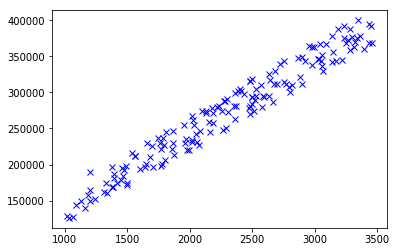

In [3]:
num_houses = 160
np.random.seed(42)
house_size = np.random.randint(low=1000, high=3500, size=num_houses)
np.random.seed(42)
house_price = house_size * 100.0 + np.random.randint(low=20000, high=70000, size=num_houses) 

plt.plot(house_size, house_price, "bx")

In [4]:
# Normalize function
def normalize(array):
    return (array - array.mean()) / array.std()

# Normalize the data 
house_size_norm = normalize(house_size)
house_price_norm = normalize(house_price)

# Split into training and test set (80/20)
num_train_samples = math.floor(num_houses * 0.8)

train_house_size_norm = house_size_norm[0:num_train_samples]
train_house_price_norm = house_price_norm[0:num_train_samples]

test_house_size_norm = house_size_norm[num_train_samples:]
test_house_price_norm = house_price_norm[num_train_samples:]

# Setup the tensorflow model, cost function and optimizer

In [5]:
# Set up the TensorFlow place holders
with tf.name_scope("Input_Data"):
    X = tf.placeholder(tf.float32, name="house_size")
    Y = tf.placeholder(tf.float32, name="price")

# Define variables to train
with tf.name_scope("Trained_Variables"):
    W = tf.Variable(np.random.randn(), name="size_factor")
    variable_summaries(W)
    b = tf.Variable(np.random.randn(), name="offset")
    variable_summaries(b)

# Setup the prediction model - simple linear regression 
predictor = tf.add(tf.multiply(W,X), b)

# Define the cost function - mean squared error (prediction - Y)^2 / 2*m
with tf.name_scope("Cost"):
    fn_cost = tf.losses.mean_squared_error(Y, predictor) #tf.reduce_sum( tf.pow(predictor - Y, 2) ) / (2*num_train_samples)

with tf.name_scope("Optimizer"):
    # Define the optimizer
    learning_rate = 0.1
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(fn_cost) 
# or use tf.train.GradientDescentOptimizer(learning_rate).minimize(fn_cost)

tf.summary.scalar("cost", fn_cost)
merged_summary = tf.summary.merge_all()


# Execute the optimizer

Training Cost=  0.0446 Size Factor= 0.97006 Offset= -0.012258641
Training Cost= 0.0461


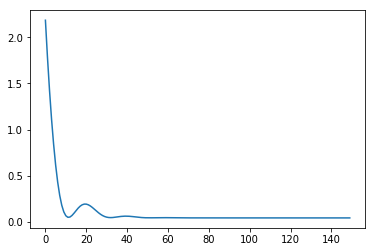

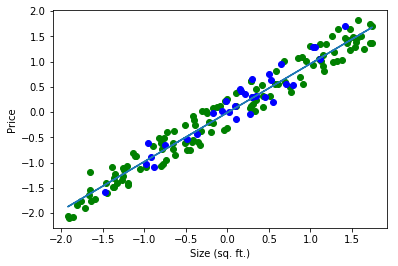

In [7]:
# Setup initialize function to initialize variables inside the execution environment
init = tf.global_variables_initializer()

# Initialize saver that will enable us to store the model
saver = tf.train.Saver()

costs = []
with tf.Session() as sess:
    sess.run(init)
    
    # Write default graph to log
    tensor_board_writer = tf.summary.FileWriter(log_path, sess.graph)

    num_training_iter = 150
    for i in range(num_training_iter):
        _, cost, _summary = sess.run([optimizer, fn_cost, merged_summary], {X: train_house_size_norm, Y:train_house_price_norm})
        costs.append(cost)
        tensor_board_writer.add_summary(_summary, i)
    
    plt.plot(costs)    
    print("Training Cost= ", "{:,.4f}".format(cost), "Size Factor=",sess.run(W), "Offset=", sess.run(b))
    
    # Calculate test cost
    test_cost = sess.run(fn_cost, {X:test_house_size_norm, Y:test_house_price_norm})
    print("Training Cost=", "{:.4f}".format(test_cost))
    
    # Plot figure to validate results - note all a ploted in normalize dimensions 
    plt.figure()
    plt.ylabel("Price")
    plt.xlabel("Size (sq. ft.)")
    plt.plot(train_house_size_norm, train_house_price_norm, 'go', label='Training data')
    plt.plot(test_house_size_norm, test_house_price_norm, 'bo', label='Test data')
    plt.plot(train_house_size_norm, (sess.run(W) * train_house_size_norm) + sess.run(b), label="Learning Regression")
    
    # Save model so we can use it for predictions
    saver.save(sess, "tmp/house_price_model.ckpt")

# Run a single prediction using a saved model

INFO:tensorflow:Restoring parameters from tmp/house_price_model.ckpt
Predicted house price for size 3000 sq.ft. = 333935.15$


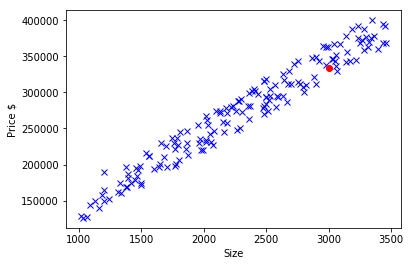

In [19]:
with tf.Session() as sess:
     
    # Load model
    saver.restore(sess, "tmp/house_price_model.ckpt")
    
    # Perform a single prediction
    example_house_size = 3000
    
    # Scale prediction to normalized scale
    example_house_size_norm = (example_house_size - house_size.mean()) / house_size.std()
    
    prediction_price_norm = sess.run(predictor, {X:example_house_size_norm})
    
    prediction_price = prediction_price_norm * house_price.std() + house_price.mean()
    
    print("Predicted house price for size", example_house_size, "sq.ft. =", "{:.2f}$".format(prediction_price))
    
    plt.figure()
    plt.ylabel("Price $")
    plt.xlabel("Size")
    plt.plot(house_size, house_price, "bx")
    plt.plot(example_house_size, prediction_price, "ro", label="Prediction")